In [306]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KDTree
import gdown
from zipfile import ZipFile
from PIL import Image, ImageOps
from scipy.spatial import distance
from scipy.stats import multivariate_normal
import seaborn as sns
import os
import json
from math import log

In [2]:
'''url =  'https://drive.google.com/uc?id=1j_EDWso-zm5wcPQMpdwKyIg1ZuD7jeBI&export=download'
output = 'datos.zip'
gdown.download(url, output, quiet=False)

with ZipFile('datos.zip', 'r') as zipObj: # Extract all the contents of zip file in current directory 
  zipObj.extractall()'''

"url =  'https://drive.google.com/uc?id=1j_EDWso-zm5wcPQMpdwKyIg1ZuD7jeBI&export=download'\noutput = 'datos.zip'\ngdown.download(url, output, quiet=False)\n\nwith ZipFile('datos.zip', 'r') as zipObj: # Extract all the contents of zip file in current directory \n  zipObj.extractall()"

In [3]:
class Kmean:
    def __init__(self, k, distance_type = 'euclidian'):
        self.k = k
        self.distance_type = distance_type
        self.reset()
    
    def reset(self):
        self.n = 0
        self.m = 0
        self.umbral = 0
        self.init_type = 'random'
        self.data = None
        self.labels = None
        self.centroids = None

    def distance(self, x, y):
        if self.distance_type == 'minkowski':
            return distance.minkowski(x,y)
        elif self.distance_type == 'manhattan':
            return distance.cityblock(x, y)
        else: #Euclidian default
            return distance.euclidean(x,y)

    def min_index_distance(self, x): #Retorna el índice del centroide más cercano a x
        distances = np.array( [self.distance(x, centroid) for centroid in self.centroids] )
        return np.argmin(distances)

    def label(self): #Etiqueta a los datos de data
        self.labels = np.array([ self.min_index_distance(x) for x in self.data ])

    def update(self):
        new_centroids = np.zeros((self.k, self.m), dtype = np.float64)
        labels_n = np.zeros(self.k, dtype = np.float64)
        for i in range(self.n):
            new_centroids[self.labels[i]] += self.data[i]
            labels_n[self.labels[i]] += 1
        for i in range(self.k):
            if labels_n[i] != 0:
                new_centroids[i] /= labels_n[i]
        return new_centroids

    def distance_to_zero(self, x):
        z = np.zeros(x.shape[0], dtype = int)
        return self.distance(x, z)

    def init(self):
        if self.init_type == 'kmeans++':
            dist_to_zero = []
            for i in range(self.n):
                dist_to_zero.append(self.distance_to_zero(self.data[i]))
            init_centroids = [self.data[ np.argmin(np.array(dist_to_zero)) ] ]
            for centroid_i in range(self.k-1):
                dist = []
                for i in range(self.n):
                    dist_i = np.array( [self.distance(self.data[i], centroid) for centroid in init_centroids] )
                    dist.append(np.amin(dist_i))
                next_centroid = self.data[ np.argmax(np.array(dist)) ]
                init_centroids.append(next_centroid)
            self.centroids = np.array(init_centroids, dtype = np.float64)
        else: #Random por defecto
            idx = np.random.choice(self.n, self.k, replace = False)
            self.centroids = self.data[idx]

    def fit(self, data, init_type = 'random', umbral = 1e-9):
        self.reset()
        self.umbral = umbral
        self.data = data
        self.n = data.shape[0]
        self.m = data.shape[1]
        self.init_type = init_type

        self.init()
        
        '''record_centroids = []
        for record_i in range(k):
            record_centroids.append([])
        for record_i in range(k):
            record_centroids[record_i].append(centroids[record_i])'''
        
        #print("centroids shape: ", self.centroids.shape)
        #print(np.transpose(self.centroids), "\n")
        i = 0
        while(1):
            i = i + 1
            self.label() #Etiquetar los datos en base a los centroides
            new_centroids = self.update()  #Actualiza los nuevos centroides
            #for record_i in range(k):
                #record_centroids[record_i].append(centroids[record_i])
            if np.all(np.absolute(self.centroids - new_centroids) < umbral):
                self.centroids = new_centroids
                break
            self.centroids = new_centroids
        print(i, "iterations")
    
    def get_labels(self):
        return self.labels
    
    def get_centroids(self):
        return self.centroids


In [307]:
class GMM:
    def __init__(self, K):
        self.K = K
        self.reset()
    
    def reset(self):
        self.n = 0
        self.m = 0
        self.labels = []

    def fit(self, data, iterations = 100, umbral = 1e-9):
        while(1):
            try:
                self.reset()
                self.n = data.shape[0]
                self.m = data.shape[1]
                pi = np.array([1.0/self.K for i in range(self.K)], dtype = np.float64)
                mu = np.random.rand(self.K, self.m)
                cov = []
                for i in range(self.K):
                    cov.append(np.cov(np.transpose(data)))
                cov = np.array(cov)
                likelihood = 0.0

                gamma = np.zeros((self.n, self.K), dtype = np.float64)
                
                iteration = 0
                while iteration < iterations:
                    # E step
                    for i in range(self.n):
                        total = 0.0
                        for k in range(self.K):
                            total = total + pi[k]*multivariate_normal.pdf(data[i], mean=mu[k], cov=cov[k])
                        for k in range(self.K):
                            gamma[i][k] = pi[k]*multivariate_normal.pdf(data[i], mean=mu[k], cov=cov[k]) / total
                    
                    # M step
                    N = np.sum(gamma, axis = 0)
                    
                    mu_new = np.zeros((self.K, self.m), dtype = np.float64)
                    for i in range(self.K):
                        for j in range(self.m):
                            mu_new[i][j] = np.dot( np.transpose(gamma)[i], np.transpose(data)[j] )
                        mu_new[i] /= N[i]
                    
                    cov_new = []
                    for k in range(self.K):
                        cov_new_k = np.zeros((self.m, self.m), dtype = np.float64)
                        for i in range(self.n):
                            new_mx = np.transpose([data[i] - mu_new[k]]) * (data[i] - mu_new[k])
                            new_mx = new_mx * gamma[i][k]
                            cov_new_k = cov_new_k + new_mx
                        cov_new_k = cov_new_k / N[k]
                        cov_new.append(cov_new_k)
                    cov_new = np.array(cov_new)
                    
                    pi_new = N / self.n
                    
                    mu = mu_new
                    cov = cov_new
                    pi = pi_new

                    # Evaluate likelihood
                    likelihood_new = 0.0
                    for i in range(self.n):
                        likelihood_k = 0.0
                        for k in range(self.K):
                            likelihood_k += pi[k] * multivariate_normal.pdf(data[i], mean=mu[k], cov=cov[k])
                        likelihood_new += log(likelihood_k)
                    
                    if abs(likelihood - likelihood_new) < umbral:
                        likelihood = likelihood_new
                        break
                    likelihood = likelihood_new
                    iteration += 1
                print(iteration, "iterations")
                for i in range(self.n):
                    self.labels.append(np.argmax(gamma[i]))
                self.labels = np.array(self.labels)
                break
            except Exception as e:
                print(e.__class__)
                if str(e) == 'singular matrix':
                    print("Singular matrix error. Repeating\n")
                    continue
                else:
                    break
        
    
    def get_labels(self):
        return self.labels
    

In [5]:
class DBScan:
    def __init__(self, r, threshold, distance_type = 'euclidean'):
        self.r = r
        self.threshold = threshold
        self.distance_type = distance_type
        self.reset()
        self.__set_flags()

    def __set_flags(self):
        self.flags = {
            "undefined": int(-1), 
            "noise": int(-2)
        }

    def __init_labels(self):
        self.labels = dict()
        for (_,_,point) in zip(self_data):
            self.labels[point] = self.flags["undefined"]

    def __build_kdtree(self, leaf_size):
        self.kdtree = KDTree(self.data, leaf_size = leaf_size)

    def reset(self):
        self.n = 0
        self.m = 0
        self.data = None
        self.labels = None

    def __init(self):
        self.__init_labels()
        leaf_size = 40
        self.__build_kdtree(leaf_size)        

    def fit(self, data):
        self.reset()
        self.__init()
        self.data = data
        self.n = data.shape[0]
        self.m = data.shape[1]

        for (i,j,point) in zip(data):
            pass

Recorrer imagen por imagen

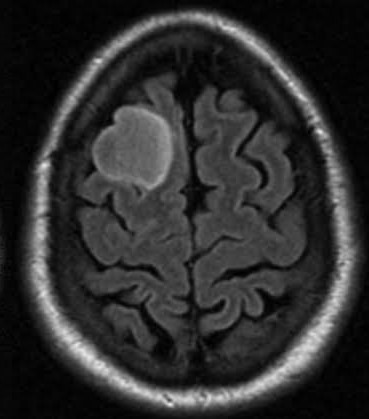

In [6]:
image = Image.open(r"/home/jneirar20/Desktop/UTEC/2022-1/Inteligencia Artificial/ia_project_2/dataset/0.jpg") 
image

In [7]:
def draw(x, y, h, w, cluster_fixed = -1, centroids = [], record_centroids = []): 
    markers = ['o', '<', 's', '*', 'h', 'p', 'v', '>']
    colors = ['b', 'g', 'm', 'c', 'y']
    k = len(x[0])
    
    s_points = 10
    if len(centroids) > 0:
        s_points = 2

    clusters = set(y)
    if -1 in clusters:
        plt.scatter(x[y == -1, 0], x[y == -1, 1], s = s_points, c = 'black', label = 'Undefined')
        clusters.remove(-1)
    clusters = list(clusters)
    
    im = 0
    ic = 0
    if cluster_fixed != -1:
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        plt.xlim(0, w)
        plt.ylim(0, h)
        plt.scatter(x[y != cluster_fixed, 0], x[y != cluster_fixed, 1], s = s_points, c = 'b', marker = 'o', alpha = 0.05)
        plt.scatter(x[y == cluster_fixed, 0], x[y == cluster_fixed, 1], s = s_points, c = 'r', marker = 'o')
        plt.show()
    else:
        for cluster_c in clusters:
            fig = plt.gcf()
            fig.set_size_inches(4, 4)
            plt.xlim(0, w)
            plt.ylim(0, h)
            ic = 0
            for cluster in clusters:
                plt.scatter(x[y == cluster, 0], x[y == cluster, 1], s = s_points, c = colors[ic], marker = 'o', alpha = 0.1)
                ic += 1
                if ic == len(colors):
                    ic = 0
            plt.scatter(x[y == cluster_c, 0], x[y == cluster_c, 1], s = s_points, c = 'r', marker = 'o')
            print("cluster:", cluster_c)
            plt.show()

In [8]:
path_project = '/home/jneirar20/Desktop/UTEC/2022-1/Inteligencia Artificial/ia_project_2/'
path = path_project + 'dataset/'
img_names = []
for file in os.listdir(path):
    if os.path.isfile(os.path.join(path, file)) and file.endswith('.jpg'):
        img_names.append(file)
img_names.sort()
print(len(img_names))

302


In [ ]:
'''data_df = np.concatenate((x_data, np.transpose([labels])), axis = 1)
column_names = ['x', 'y', 'color_values', 'classes']
df = pd.DataFrame(data = data_df, columns = column_names)
sns.set(rc={'figure.figsize':(12,12)})
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'classes')'''

Iniciar iteraciones

In [289]:
i_image = 0
w = 50
h = 50
image = Image.open(path + img_names[i_image])
image = image.resize((h, w))
image = ImageOps.grayscale(image)
arr_image = np.array(image)
#image.show()
x_data = []
for i in range(arr_image.shape[0]):
  for j in range(arr_image.shape[1]):
    x_data.append([j, arr_image.shape[0] - i, arr_image[i][j]])
x_data = np.array(x_data)
print(img_names[i_image])

0.jpg


In [308]:
gmm = GMM(20)    #kmean = Kmean(k = 25)
gmm.fit(x_data)    #kmean.fit(x_data, init_type = 'kmeans++')
#labels = gmm.get_labels()   #labels = kmean.get_labels()
#draw(x_data, labels, w, h)

KeyboardInterrupt: 

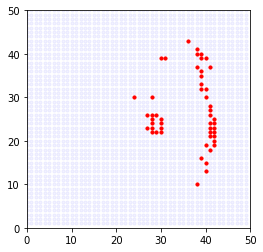

In [244]:
draw(x_data, labels, w, h, 20)

In [288]:
cluster = 11

path_json = path_project + 'data1_Kmean.json'
'''
# Para el inicio:
matriz = x_data[labels == cluster]
data = {"name": img_names[i_image], "points": matriz.shape[0], "vector": matriz.tolist()}
dic = {"n_data": 1, "data": [data]}
with open(path_json, "w+") as of:
   json.dump(dic,of)

'''

matriz = x_data[labels == cluster]
data = {"name": img_names[i_image], "points": matriz.shape[0], "vector": matriz.tolist()}

with open(path_json) as f:
   obj = json.load(f) 
obj["data"].append(data)
obj["n_data"] += 1

with open(path_json, "w+") as of:
   json.dump(obj,of)


In [107]:
'''with open(path_json) as f:
   obj = json.load(f)
datadata = obj["data"]
points = np.array(datadata[0]['vector'])
print(points.shape)
'''

(41, 3)
